In [39]:
import os 
os.chdir("/home/zazza/Documents/ML/Fine-Grained-Visual-Classification/utility/gradcam")

In [40]:
from pytorch_grad_cam.grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [41]:
from torchvision.models import efficientnet_b5
import torchvision.transforms as transforms

In [42]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont

In [43]:
import torch

def model_load_checkpoint(model, path):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    return model

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [44]:
from torchvision.models import resnet50
os.chdir("/home/zazza/Documents/ML/Fine-Grained-Visual-Classification")
from methods.CMAL.builder_resnet import Network_Wrapper
model = resnet50(weights="DEFAULT")

net_layers = list(model.children())
net_layers = net_layers[0:8]

model = Network_Wrapper(net_layers, 100)

model = model_load_checkpoint(model, "/home/zazza/Documents/ML/Fine-Grained-Visual-Classification/experiments/ResNet50_CMAL_FGVCAircraft_Big/checkpoint.pth")

In [45]:
import timm

# Load the pre-trained Swin Transformer model
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

In [46]:
from methods.CMAL.highlight_images import test
import torch.nn as nn

CELoss = nn.CrossEntropyLoss()
# test(model, CELoss,1 ,'/home/zazza/Documents/ML/Fine-Grained-Visual-Classification/data/fgvc-aircraft-2013b/data/test')

In [47]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [48]:
print(model.layers[-1].blocks)

Sequential(
  (0): SwinTransformerBlock(
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): WindowAttention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
    (drop_path1): DropPath(drop_prob=0.091)
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (drop_path2): DropPath(drop_prob=0.091)
  )
  (1): SwinTransformerBlock(
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): WindowAttention(

In [49]:
def plot_grad_cam(model, target_class, img, dim=224, save_path=None):
    """
    img: PIL image
    """
    
    model.eval()
    
    if model.__class__.__name__ == 'ResNet':
        target_layers = [model.layer4[-1]]
    elif model.__class__.__name__ == 'EfficientNet':
        target_layers = [model.features[-2][-2]]
    elif model.__class__.__name__ == 'VisionTransformer':
        target_layers = [model.encoder.layers.encoder_layer_11.ln_1]
    elif model.__class__.__name__ == 'SwinTransformer':
        target_layers = [model.layers[-1].blocks[-1]]
    elif model.__class__.__name__ == 'Network_Wrapper':
        target_layers = [model.Features.net_layer_7[-1]]
    else:
        raise ValueError('Model not supported')
    
    if model.__class__.__name__ == 'VisionTransformer':
        cam = GradCAM(model=model, target_layers=target_layers,reshape_transform=reshape_transform)
    else:
        cam = GradCAM(model=model, target_layers=target_layers)

    transform = transforms.Compose([
        transforms.Resize((dim, dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    input_tensor = transform(img)

    targets = [ClassifierOutputTarget(target_class)]

    if model.__class__.__name__ == 'Network_Wrapper':
        grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]    
    else:
        grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]

    img = img.resize((dim, dim))
    img = np.float32(img) / 255

    cam_image_array = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    cam_image = Image.fromarray(cam_image_array)
    
    if save_path:
        cam_image.save(save_path)
    
    return cam_image

def grad_cam_viz_with_pred(model, target_class, img, prediction, ground_truth, dim=224, save_path=None):
    cam_image = plot_grad_cam(model, target_class, img, dim=dim, save_path=None)

    draw = ImageDraw.Draw(cam_image)
    
    # Define the text to be drawn
    text = f"GT: {ground_truth}, Pred: {prediction}"
    
    # Choose a font and size (you can choose a different font if you have it)
    try:
        font = ImageFont.truetype("arial.ttf", 40)
    except IOError:
        font = ImageFont.load_default()
    
    # Define text position and color
    position = (10, 10)  # top left corner
    color = (255, 0, 0)  # red color
    
    # Draw the text on the image
    draw.text(position, text, fill=color, font=font)

    if save_path:
        cam_image.save(save_path)

    return cam_image

In [50]:
import torch

In [51]:
from torchvision.datasets import FGVCAircraft
data = FGVCAircraft(root="/home/zazza/Documents/ML/Fine-Grained-Visual-Classification/data", download=True)

In [52]:
import torchvision 
os.chdir("/home/zazza/Documents/ML/Fine-Grained-Visual-Classification/")
from utility.data.preprocessing import Autoaugment_preprocess
transform = Autoaugment_preprocess(channels=3, resize_dim=(300,323), crop_dim=(224,224)) 

root = "/home/zazza/Documents/ML/Fine-Grained-Visual-Classification/" # change this to your data directory

testset_images = torchvision.datasets.Flowers102(root=root+"/data", split="test",
                                                 download=True, transform=None)

testset = torchvision.datasets.Flowers102(root=root+"/data", split="test",
                                          download=True, transform=transform.transform)


In [53]:
# with swinT
#from torchvision.models import swin_t
#model = swin_t(weights=None)
#model.head = torch.nn.Linear(768, 102, bias=True)
#model = model_load_checkpoint(model, "/home/zazza/Documents/ML/Fine-Grained-Visual-Classification/experiments/SwinT_Flower102/checkpoint.pth")

<class 'timm.models.swin_transformer.SwinTransformerBlock'>
SwinTransformerBlock(
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): WindowAttention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
    (softmax): Softmax(dim=-1)
  )
  (drop_path1): DropPath(drop_prob=0.100)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (drop_path2): DropPath(drop_prob=0.100)
)
<class 'timm.models.swin_transformer.SwinTransformerBlock'>


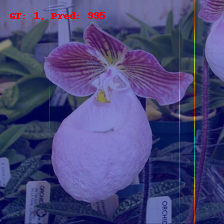

In [54]:
grad_cam_viz_with_pred(model=model,
                        target_class=60, 
                        dim=224, 
                        img=testset_images[20][0], 
                        prediction=model(testset[20][0].unsqueeze(0)).argmax().item(), 
                        ground_truth=testset[20][1])